In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.1 MB/s 
     |████████████████████████████████| 7.6 MB 44.3 MB/s 
     |████████████████████████████████| 182 kB 60.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 32.0 MB/s 
     |████████████████████████████████| 212 kB 79.6 MB/s 
     |████████████████████████████████| 132 kB 75.7 MB/s 
     |████████████████████████████████| 127 kB 72.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper

### Model

In [ ]:
from transformers import AutoTokenizer, BertModel, AutoModelForSequenceClassification, AdamW, get_scheduler
from datasets import Dataset, load_metric
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader,SequentialSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import notebook
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# change pretrained models? ## S: No
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-esg',model_max_length=256)
esg_bert = BertModel.from_pretrained('yiyanghkust/finbert-esg',output_attentions=True) 

Downloading:   0%|          | 0.00/781 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the model checkpoint at yiyanghkust/finbert-esg were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/'NLP Final Project'

/content/drive/MyDrive/NLP Final Project


In [ ]:
final_dataset = pd.read_csv("final_dataset_new.csv")

In [ ]:
final_dataset

,symbol,year,truncated_text,score
0,a,2016,if it meets it will likely react the way the a...,0.884762
1,a,2021,we’ve changed lives for the better and took mo...,0.886514
2,aal,2020,"$jets, $play, &amp; $aal gains [ericsson profi...",0.622026
3,aal,2021,$aal lets gooooooo! $aal letsssss gooooooooooo...,0.685919
4,aap,2016,with all these uber and lyft cars on these str...,0.333698
...,...,...,...,...
837,xray,2021,"as of now, only about ⅓ of align’s customers a...",0.678117
838,xyl,2020,the applied water segment encompasses the uses...,0.826304
839,yum,2021,can nuggets do the same? i don't care.tldr – *...,0.772902
840,zts,2016,$pzza- buy a 75/80 nov16 call spread or sell n...,0.452652


In [ ]:
from sklearn.model_selection import train_test_split
train_text,val_text,train_score,val_score = train_test_split(list(final_dataset["truncated_text"]),list(final_dataset["score"]),test_size=0.2)

In [ ]:
def getGrade(score):
    if score <= 0.25:
        return 0
    elif score <= 0.50:
        return 1
    elif score <= 0.75:
        return 2
    elif score <= 1:
        return 3

In [ ]:
train_grade = [getGrade(score) for score in train_score]
val_grade = [getGrade(score) for score in val_score]

In [ ]:
train_dataset = pd.DataFrame({"train_text":train_text,"train_grade":train_grade})
val_dataset = pd.DataFrame({"val_text":val_text,"val_grade":val_grade})

In [ ]:
train_encoding = tokenizer(train_text, truncation=True, padding=True)
val_encoding = tokenizer(val_text, truncation=True, padding=True)

In [ ]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = RedditDataset(train_encoding, train_grade)
val_dataset = RedditDataset(val_encoding, val_grade)

In [ ]:
def freeze_model(model):
    for param in model.base_model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.base_model.parameters():
        param.requires_grad = True

In [ ]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler,batch_size=4)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=4)

## New Model
---



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg', num_labels=4, ignore_mismatched_sizes=True)
freeze_model(model) ## Freezes model

optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-04, eps=1e-08)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
train_losses = []
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        train_losses.append(float(loss))
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1690 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
val_losses = []
metric = load_metric("accuracy")

model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits

    loss = outputs.loss
    val_losses.append(float(loss))

    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

<ipython-input-31-d57a4c8b938f>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


{'accuracy': 0.5266272189349113}

In [ ]:
# Changed
train_losses = []
val_losses = []
metric = load_metric("accuracy")
progress_bar = tqdm(range(num_epochs))

for epoch in range(num_epochs):
    train_loss_batch = []
    val_loss_batch = []

    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        train_loss_batch.append(float(loss))
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    for batch in val_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits

      loss = outputs.loss
      val_loss_batch.append(float(loss))

      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
    
    train_losses.append(sum(train_loss_batch)/len(train_loss_batch))
    val_losses.append(sum(val_loss_batch)/len(val_loss_batch))
    progress_bar.update(1)
    print(train_losses)


  0%|          | 0/10 [00:00<?, ?it/s]

[1.0473762151052262]
[1.0473762151052262, 1.042786431206754]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273, 1.0273798573651962]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273, 1.0273798573651962, 1.022115645676675]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273, 1.0273798573651962, 1.022115645676675, 1.0120199825284044]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273, 1.0273798573651962, 1.022115645676675, 1.0120199825284044, 1.010006420005708]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273, 1.0273798573651962, 1.022115645676675, 1.0120199825284044, 1.010006420005708, 1.0145283923346615]
[1.0473762151052262, 1.042786431206754, 1.0320884222109643, 1.0380754432029273, 1.0273798573651962, 1.022

In [ ]:
model.save_pretrained('./final-models/finbert-esg-reddit-classification')

In [ ]:
from keras.optimizers import adamax_v2
def plot_over_training(per_epoch_metrics, title_name: str):
    """Utility function to plot train/val accuracies and losses.

    @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
        course of training.
    @param title_name: String to show on the plot title.
    """
    t_train = np.arange(0, len(per_epoch_metrics['train_losses']))
    train_loss = per_epoch_metrics['train_losses']

    t_val = np.arange(0, len(per_epoch_metrics['val_losses']))
    val_loss = per_epoch_metrics['val_losses']

    fig, (ax1,ax2) = plt.subplots(2,1)

    color = 'tab:blue'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(t_train, train_loss, color=color, linewidth=1, label = 'train_loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.title.set_text(title_name)

    color = 'tab:red'
    ax2.set_ylabel('loss', color=color)
    ax2.plot(t_val, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper left')
    ax2.title.set_text(title_name)

    fig.tight_layout() 
    plt.show()

In [ ]:
per_epoch_metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
}

title_name = 'Classification: freeze_model, lr=2e-04, eps=1e-08'

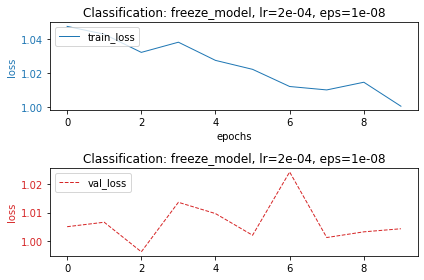

In [ ]:
plot_over_training(per_epoch_metrics=per_epoch_metrics, title_name=title_name)